In [1]:
import os
import sys
import cProfile
import numpy as np
import scipy.stats
from n2j.inference.inference_manager import InferenceManager

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
IN_DIR = '/home/jwp/stage/sl/n2j/n2j/data'  # where raw data lies
TRAIN_HP = [10327]
VAL_HP = [10326]
N_TRAIN = [20000]
N_VAL = 20000  # needs to be higher than number used, for subsampling
BATCH_SIZE = 1000  # min(N_TRAIN//5, 50)
CHECKPOINT_PATH = "/home/jwp/stage/sl/n2j/results/E3/N2JNet_epoch=198_07-12-2021_06:36.mdl"
SUB_TARGET = ['final_kappa', ]  # 'final_gamma1', 'final_gamma2']
SUB_TARGET_LOCAL = ['stellar_mass', 'redshift']
CHECKPOINT_DIR = '../results/E3'
OUT_DIR = '../inference_results/E3'
SKIP_RAYTRACING = True
RUN_MCMC = True

In [3]:
##############
# Graphs (X) #
##############

features = ['galaxy_id', 'ra', 'dec', 'redshift']
features += ['ra_true', 'dec_true', 'redshift_true']
features += ['ellipticity_1_true', 'ellipticity_2_true']
features += ['bulge_to_total_ratio_i']
features += ['ellipticity_1_bulge_true', 'ellipticity_1_disk_true']
features += ['ellipticity_2_bulge_true', 'ellipticity_2_disk_true']
features += ['shear1', 'shear2', 'convergence']
features += ['size_bulge_true', 'size_disk_true', 'size_true']
features += ['mag_{:s}_lsst'.format(b) for b in 'ugrizY']
# Features to train on
sub_features = ['ra_true', 'dec_true']
# sub_features += ['size_true']
# sub_features += ['ellipticity_1_true', 'ellipticity_2_true']
sub_features += ['mag_{:s}_lsst'.format(b) for b in 'ugrizY']
norm_obj = scipy.stats.norm(loc=0.01, scale=0.03)
infer_obj = InferenceManager('cuda',
                             checkpoint_dir=CHECKPOINT_DIR,
                             out_dir=OUT_DIR,
                             seed=1028)

infer_obj.load_dataset(
                       dict(features=features,
                            raytracing_out_dirs=[os.path.join(IN_DIR, f'cosmodc2_{hp}/Y_{hp}') for hp in TRAIN_HP],
                            healpixes=TRAIN_HP,
                            n_data=N_TRAIN,
                            aperture_size=1.0,
                            subsample_pdf_func=norm_obj.pdf,
                            stop_mean_std_early=False,
                            in_dir=IN_DIR),
                       sub_features=sub_features,
                       sub_target=SUB_TARGET,
                       sub_target_local=SUB_TARGET_LOCAL,
                       is_train=True,
                       batch_size=BATCH_SIZE,
                       rebin=False,
                       )
# FIXME: must be run after train
infer_obj.load_dataset(
                       dict(features=features,
                            raytracing_out_dirs=[os.path.join(IN_DIR, f'cosmodc2_{hp}/Y_{hp}') for hp in VAL_HP],
                            healpixes=VAL_HP,
                            n_data=[N_VAL]*len(VAL_HP),
                            aperture_size=1.0,
                            in_dir=IN_DIR),
                       sub_features=sub_features,
                       sub_target=SUB_TARGET,
                       is_train=False,
                       batch_size=BATCH_SIZE,  # FIXME: must be same as train
                      )
# Redefine validation data to be the subset
norm_obj_val = scipy.stats.norm(loc=0.04, scale=0.005)
infer_obj.reset_val_dataset(norm_obj_val.pdf, n_val=1000)

# Define model
model_kwargs = dict(dim_in=infer_obj.X_dim,
                    dim_out_local=len(SUB_TARGET_LOCAL),
                    dim_out_global=len(SUB_TARGET),
                    dim_local=50,
                    dim_global=50,
                    dim_hidden=50,
                    dim_pre_aggr=50,
                    n_iter=5,
                    n_out_layers=5,
                    dropout=0.04,
                    global_flow=False,
                    device_type=infer_obj.device_type
                    )
infer_obj.configure_model('N2JNet', model_kwargs)

# Load trained model
infer_obj.load_state(CHECKPOINT_PATH)


The test dataset now has size 1000
Number of params: 170906
Loaded weights at /home/jwp/stage/sl/n2j/results/E3/N2JNet_epoch=198_07-12-2021_06:36.mdl
Epoch [198]: TRAIN Loss: -671.6081
Epoch [198]: VALID Loss: -637.9841


In [4]:
# Hierarchical reweighting
p0 = np.array([[0.04, np.log(0.005)]])
p0 = p0 + np.random.randn(100, 2)*np.array([[0.01, 0.5]])
mcmc_kwargs = dict(p0=p0,
                   n_run=100,
                   n_burn=2000,
                   chain_path=os.path.join(OUT_DIR, 'omega_chain.h5'),
                   n_walkers=100,
                   plot_chain=True,
                   clear=False
                   )

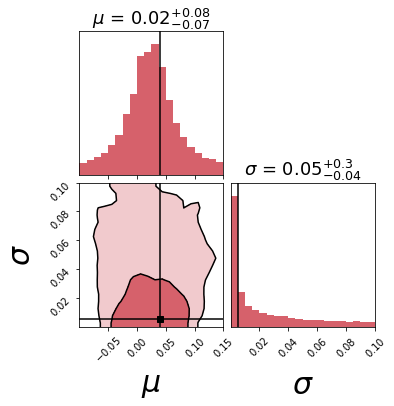

In [5]:
infer_obj.visualize_omega_post(log_idx=1,
                               chain_path=mcmc_kwargs['chain_path'],
                               corner_kwargs=dict(
                                                 range=[[-0.1, 0.15], [0, 0.1]],
                                                 color='#d6616b',
                                                 smooth=1.0,
                                                 alpha=1.0,
                                                 truths=np.array([0.04, 0.005]),
                                                 label_kwargs={'fontsize': 30},
                                                 labels=[r'$\mu$', r'$\sigma$'],
                                                 fill_contours=True,
                                                 plot_datapoints=False,
                                                 plot_contours=True,
                                                 show_titles=True,
                                                 levels=[0.68, 0.95],
                                                 truth_color='k',
                                                 contour_kwargs=dict(linestyles='solid', colors='k'),
                                      #contourf_kwargs=dict(colors='#843c39'),
                                                 quiet=True,
                                                 #quantiles=[0.5 - 0.34, 0.5 + 0.34],
                                                 title_fmt=".1g",
                                                 fig=None,
                                                 title_kwargs={'fontsize': 18},
                                                 #range=[0.99]*len(cols_to_plot),
                                                 use_math_text=True,
                                                 hist_kwargs=dict(density=True, 
                                                                  histtype='stepfilled',))
                                                 ,
                               chain_kwargs=dict(
                                                 flat=True,
                                                 thin=1,
                                                 discard=0
                                                 ))

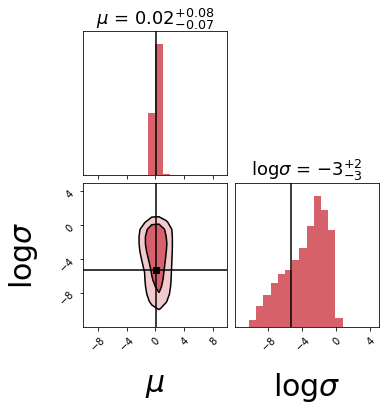

In [9]:
infer_obj.visualize_omega_post(log_idx=None,
                               chain_path=mcmc_kwargs['chain_path'],
                               corner_kwargs=dict(
                                                 range=[[-10, 10], [-12, 5]],
                                                 color='#d6616b',
                                                 smooth=0.8,
                                                 alpha=1.0,
                                                 truths=np.array([0.04, np.log(0.005)]),
                                                 label_kwargs={'fontsize': 30},
                                                 labels=[r'$\mu$', r'$\log \sigma$'],
                                                 fill_contours=True,
                                                 plot_datapoints=False,
                                                 plot_contours=True,
                                                 show_titles=True,
                                                 levels=[0.68, 0.95],
                                                 truth_color='k',
                                                 contour_kwargs=dict(linestyles='solid', colors='k'),
                                      #contourf_kwargs=dict(colors='#843c39'),
                                                 quiet=True,
                                                 #quantiles=[0.5 - 0.34, 0.5 + 0.34],
                                                 title_fmt=".1g",
                                                 fig=None,
                                                 title_kwargs={'fontsize': 18},
                                                 #range=[0.99]*len(cols_to_plot),
                                                 use_math_text=True,
                                                 hist_kwargs=dict(density=True, 
                                                                  histtype='stepfilled',))
                                                 ,
                               chain_kwargs=dict(
                                                 flat=True,
                                                 thin=1,
                                                 discard=0
                                                 ))

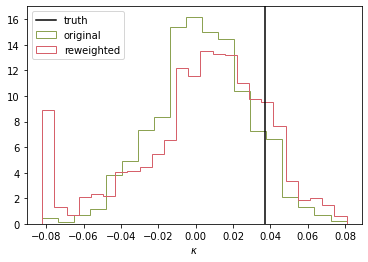

In [7]:
infer_obj.visualize_kappa_post(idx=0, n_samples=50, n_mc_dropout=20,
                               chain_path=mcmc_kwargs['chain_path'], 
                               chain_kwargs=dict(
                                                 flat=True,
                                                 thin=1,
                                                 discard=0
                                                 ))